# LDA

1. Standardize $d$-dimensional dataset 
2. Compute mean vector for each class $C_i$ as $\mathbf{m}_i = \frac{1}{n_i} \sum_{\mathbf{x} \in C_i} \mathbf{x}$
3. Compute eigenpairs of $\mathbf{S}_w^{-1}\mathbf{S}_b$ for within class scatter matrix $\mathbf{S}_w^{-1}$ and between class scatter matrix $\mathbf{S}_b^{-1}$
4. Construct $d \times k$ dimensional matrix $\mathbf{W}$ from the $k < d$ eigenvectors with the largest eigenvalues
5. Project the dataset using transformation matrix $\mathbf{W}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from plot_decision_regions import plot_decision_regions

from initialize_wine import *

np.set_printoptions(precision=4, suppress=True)
labels = np.unique(y_train)
d = X_train.shape[1]

print('Classes: {}'.format(labels))
print('Class label distribution: {}'.format(np.bincount(y_train)[1:]))

Classes: [1 2 3]
Class label distribution: [41 50 33]


In [2]:
mean_vecs = []
for class_label in labels:
    mean_vecs.append(np.mean(X_train_std[y_train == class_label], axis=0))    
    print('MV %s: %s\n' % (class_label, mean_vecs[class_label-1]))

MV 1: [ 0.8998 -0.36    0.301  -0.743   0.4679  0.9176  0.9809 -0.6287  0.6403
  0.2018  0.4958  0.7642  1.1697]

MV 2: [-0.9191 -0.3613 -0.367   0.2926 -0.4362 -0.1187  0.0098  0.1098 -0.0235
 -0.8556  0.372   0.2343 -0.7699]

MV 3: [ 0.2748  0.9947  0.1821  0.4798  0.0796 -0.9602 -1.2334  0.6148 -0.7599
  1.0456 -1.1796 -1.3044 -0.2868]



$\mathbf{S}_w = \sum_{i=1}^c \frac{1}{n_i} \sum_{\mathbf{x} \in C_i} (\mathbf{x} - \mathbf{m}_i) (\mathbf{x} - \mathbf{m}_i)^T$

In [3]:
S_w = np.zeros((d, d))
for label, mv in zip(labels, mean_vecs):
    S_i = np.zeros((d,d))
    n_i = X_train_std[y_train==label].shape[0]
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        # Although mathematically correct, gives incorrect results due to unprecision
        # S_i += (row - mv) @ (row - mv).T
        S_w += np.cov(X_train_std[y_train==label].T)
    # S_w += (1 / n_i) * S_i
    
print('Within-class scatter matrix: {}x{}'.format(S_w.shape[0], S_w.shape[1]))

Within-class scatter matrix: 13x13


$\mathbf{S}_b = \sum_{i=1}^{c} n_i (\mathbf{m}_i - \mathbf{m}) (\mathbf{m}_i - \mathbf{m})^T$

$\sum_{i=1}^{c} n_i (\mathbf{m} - \mathbf{m}) = 0$

$\mathrm{rank}(n_i (\mathbf{m}_i - \mathbf{m}) (\mathbf{m}_i - \mathbf{m})^T) \leq 1 \, \text{(it is outer product of two vectors, the any column is proportional to all the others)} \implies \mathrm{rank}(\mathbf{S}_b) \leq c-1$

In [4]:
S_b = np.zeros((d,d))
m = np.mean(X_train_std, axis=0).reshape(d, 1)
for label, mv in zip(labels, mean_vecs):
    n_i = X_train_std[y_train==label].shape[0]
    mv = mv.reshape(d, 1)
    S_b += n_i * (mv - m) @ (mv - m).T

print('Between-class scatter matrix: {}x{}'.format(S_b.shape[0], S_b.shape[1]))
print('Its rank: {} '.format(np.linalg.matrix_rank(S_b)))

Between-class scatter matrix: 13x13
Its rank: 2 


In [5]:
eigenvals, eigenvecs = np.linalg.eig(np.linalg.inv(S_w) @ S_b)
eigenpairs = sorted([(np.abs(eigenvals[i]), eigenvecs[i]) for i in range(len(eigenvals))], key=lambda d: d[0], reverse=True)

print('Eigenvals - linear discriminants:')
for eigenpair in eigenpairs:
    print('{:.5f}'.format(eigenpair[0]))

Eigenvals - linear discriminants:
9.45555
4.39717
0.00000
0.00000
0.00000
0.00000
0.00000
0.00000
0.00000
0.00000
0.00000
0.00000
0.00000


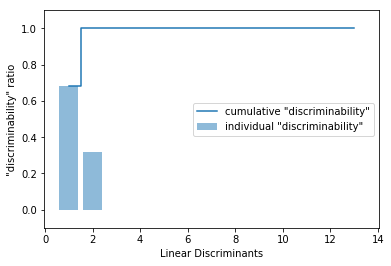

In [6]:
tot = sum(eigenvals.real)

discr = [(i / tot) for i in sorted(eigenvals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, 14), discr, alpha=0.5, align='center', label='individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid', label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.show()

The first two LDs capture 100% of the variance!

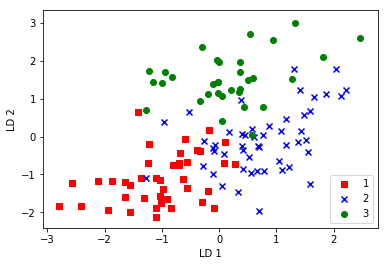

In [7]:
# Can't transpose an array
W = np.hstack((eigenpairs[0][1][:, np.newaxis].real, eigenpairs[1][1][:, np.newaxis].real))
X_train_lda = X_train_std @ W
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(labels, colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0], X_train_lda[y_train==l, 1] * (-1), c=c, label=l, marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.show()

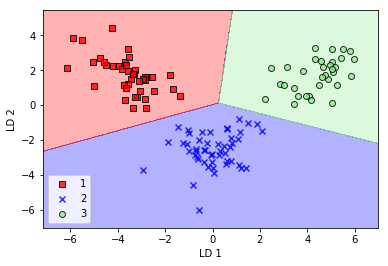

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)

X_train_lda = lda.fit_transform(X_train_std, y_train)

lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)

plot_decision_regions(X_train_lda, y_train, classifier=lr)

plt.xlabel('LD 1')
plt.ylabel('LD 2')

plt.legend(loc='lower left')

plt.show()

In [10]:
X_train_lda.shape

(124, 2)